In [1]:
import seaborn as sns
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
import scipy.stats as st

from matplotlib import pyplot as plt

from jupyterthemes import jtplot
jtplot.style(theme='chesterish')

%matplotlib inline

In [2]:
OUTPUT_DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness/output"
INPUT_DATA_DIR = "~/jupyter_notebooks/DATA/MarchMadness/MDataFiles_Stage2"

YEAR = 2021

In [3]:
# https://www.kaggle.com/c/ncaam-march-mania-2021/data
teams_df = pd.read_csv(f"{INPUT_DATA_DIR}/MTeams.csv")
seeds_df = pd.read_csv(f"{INPUT_DATA_DIR}/MNCAATourneySeeds.csv")
reg_detailed_results_df = pd.read_csv(f"{INPUT_DATA_DIR}/MRegularSeasonDetailedResults.csv")
reg_compact_results_df = pd.read_csv(f"{INPUT_DATA_DIR}/MRegularSeasonCompactResults.csv")
tournament_results_df = pd.read_csv(f"{INPUT_DATA_DIR}/MNCAATourneyCompactResults.csv")
raw_ordinal_df = pd.read_csv(f"{INPUT_DATA_DIR}/MMasseyOrdinals.csv")

In [4]:
raw_ordinal_df

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12
3,2003,35,SEL,1105,314
4,2003,35,SEL,1106,260
...,...,...,...,...,...
4339291,2021,133,WOB,1467,233
4339292,2021,133,WOB,1468,176
4339293,2021,133,WOB,1469,290
4339294,2021,133,WOB,1470,256


In [5]:
RANK = "POM"
rank_days = raw_ordinal_df[raw_ordinal_df["SystemName"] == RANK].groupby(["Season"]).max()["RankingDayNum"].reset_index()
rank_indices = list(rank_days.itertuples(index=False, name=None))
rank_lookup = raw_ordinal_df[raw_ordinal_df["SystemName"] == RANK].set_index(["Season", "RankingDayNum"])
rank_df = rank_lookup.loc[rank_indices]
ordinal_pivot_df = pd.pivot_table(
    rank_df, values='OrdinalRank', index=['Season', 'TeamID'], columns=['SystemName']
)[[RANK]].rename(columns={RANK: "Rank"})
ordinal_pivot_df

SystemName      Rank
Season TeamID       
2003   1102    160.0
       1103    163.0
       1104     33.0
       1105    307.0
       1106    263.0
...              ...
2021   1467    270.0
       1468    180.0
       1469    323.0
       1470    260.0
       1471    236.0

[6521 rows x 1 columns]

In [6]:
IS_COMPACT = True
MIN_RANK_SEASON = ordinal_pivot_df.reset_index()["Season"].min()
STATS = {'Score'} if IS_COMPACT else {
    'Score',
    'FGM', 'FGA', 'FGM3', 'FGA3', 'FTM', 'FTA',
    'OR', 'DR', 'Ast', 'TO', 'Stl', 'Blk', 'PF'    
}
SHARED = {
    'Season', 'DayNum', 'NumOT'
}
reg_results_df = reg_compact_results_df if IS_COMPACT else reg_detailed_results_df
reg_results_df = reg_results_df[reg_results_df["Season"] >= MIN_RANK_SEASON]
reg_results_df

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
74048,2003,10,1104,68,1328,62,N,0
74049,2003,10,1272,70,1393,63,N,0
74050,2003,11,1266,73,1437,61,N,0
74051,2003,11,1296,56,1457,50,N,0
74052,2003,11,1400,77,1208,71,N,0
...,...,...,...,...,...,...,...,...
170733,2021,132,1382,74,1433,65,N,0
170734,2021,132,1159,85,1259,72,H,0
170735,2021,132,1104,80,1261,79,N,0
170736,2021,132,1222,91,1153,54,N,0


In [7]:
# Split single W & L row into two rows, one for winner one for loser
games = reg_results_df.to_dict('records')
games_dicts = []
for game in tqdm(games):
    game["LLoc"] = "H" if game["WLoc"] == "A" else "A"
    game["WLoc"] = game["WLoc"] if game["WLoc"] != "N" else "A"
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    w_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_own_dict = {
        f"Own{k[1:]}": v
        for k, v in game.items()
        if k.startswith("L") and k not in SHARED
    }
    l_opp_dict = {
        f"Opp{k[1:]}": v
        for k, v in game.items()
        if k.startswith("W") and k not in SHARED
    }
    w_dict = {**both_dict, **w_own_dict, **w_opp_dict, **{"OppTeamID": game["LTeamID"]}}
    l_dict = {**both_dict, **l_own_dict, **l_opp_dict, **{"OppTeamID": game["WTeamID"]}}
    games_dicts.append(w_dict)
    games_dicts.append(l_dict)

100%|██████████| 96690/96690 [00:01<00:00, 93374.47it/s]


In [8]:
# Calculate each teams home and away season averages
games_df = pd.DataFrame(games_dicts)
mean_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).mean().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)
std_df = games_df.groupby(["Season", "OwnTeamID", "OwnLoc"]).std().drop(["DayNum", "NumOT", "OppTeamID"], axis=1)

In [9]:
def flip_key(key):
    if key.startswith("Own"):
        return key.replace("Own", "Opp")
    if key.startswith("Opp"):
        return key.replace("Opp", "Own")
    raise ValueError

In [10]:
# Calculate z scores for each game for:
# 1) opp performance (how did my opp do relative to how they do against others?)
# 2) own performance (how did I do relative to how others do against my opp?)
z_dicts = []
opp_keys = [k for k in games_dicts[0].keys() if k.startswith("Opp") and k in mean_df.columns]
own_keys = [k for k in games_dicts[0].keys() if k.startswith("Own") and k in mean_df.columns]
for game in tqdm(games_dicts):
    means = mean_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    stds = std_df.loc[(game["Season"], game["OppTeamID"], game["OppLoc"])]
    both_dict = {
        k: v
        for k, v in game.items()
        if k in SHARED
    }
    opp_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in opp_keys
    }
    own_stat_dict = {
        f"{k}_Zscore": (
            game[k] - means[flip_key(k)]
        ) / (
            stds[flip_key(k)]
        )
        for k in own_keys
    }
    z_dicts.append({
        **both_dict, **own_stat_dict, **opp_stat_dict,
         **{"OwnTeamID": game["OwnTeamID"], "OppTeamID": game["OppTeamID"]}
    })

100%|██████████| 193380/193380 [00:31<00:00, 6121.08it/s]


In [11]:
# Get season average z scores
z_df = pd.DataFrame(z_dicts)
z_score_mean_df = z_df.rename(columns={"OwnTeamID": "TeamID"}).groupby(["Season", "TeamID"]).mean().drop(
    ["DayNum", "NumOT", "OppTeamID"], axis=1
)

# Add rank
z_score_mean_df["Rank"] = ordinal_pivot_df["Rank"]
z_score_mean_df

OwnScore_Zscore  OppScore_Zscore   Rank
Season TeamID                                         
2003   1102          -1.127532        -1.201184  160.0
       1103           0.539325         0.569464  163.0
       1104           0.144799        -0.335313   33.0
       1105          -0.024473         0.603600  307.0
       1106          -0.632613        -0.607981  263.0
...                        ...              ...    ...
2021   1467          -0.647205        -0.450390  270.0
       1468           0.125636        -0.039074  180.0
       1469          -0.192879         0.563021  323.0
       1470          -0.359077        -0.524237  260.0
       1471           0.242415         0.482332  236.0

[6534 rows x 3 columns]

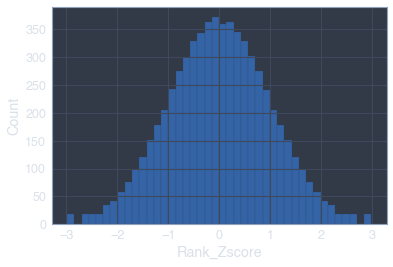

In [12]:
max_rank_lookup = z_score_mean_df.groupby("Season").max()["Rank"]

def rank_to_zscore(row):
    season, team_id = row.name
    max_rank = max_rank_lookup[season]
    # Adjust for 100% by bumping teams down half a ranking
    percentile = 1 - ((row["Rank"] - 0.5) / max_rank)      
    return st.norm.ppf(percentile)

z_score_mean_df["Rank_Zscore"] = z_score_mean_df.apply(rank_to_zscore, axis=1)
sns.histplot(z_score_mean_df["Rank_Zscore"], color='b');

In [13]:
# Dominance & Competition
z_score_mean_df["Dominance"] = z_score_mean_df["OwnScore_Zscore"] - z_score_mean_df["OppScore_Zscore"]

def get_competition_scores(lookup_df):
    sos_scores = []
    for game in games_dicts:
        try:
            sos = lookup_df.at[(game["Season"], game["OppTeamID"]), "Rank_Zscore"]
        except KeyError as e:
            # Not all teams have ranks (could default to min rank?)
            sos = lookup_df.loc[game["Season"]]["Rank_Zscore"].min()
        
        sos_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "SOS": sos
        })

    
    sos_df = pd.DataFrame(sos_scores).groupby(["Season", "TeamID"]).mean()
    lookup_df["SOS"] = sos_df["SOS"]

    comp_scores = []
    for game in games_dicts:
        try:
            comp = lookup_df.at[(game["Season"], game["OppTeamID"]), "SOS"]
        except KeyError as e:
            # Not all teams have ranks (could default to min rank?)
            comp = lookup_df.loc[game["Season"]]["SOS"].min()
        
        comp_scores.append({
            "Season": game["Season"],
            "TeamID": game["OwnTeamID"],
            "Competition": comp
        })

    comp_df = pd.DataFrame(comp_scores).groupby(["Season", "TeamID"]).mean()
    lookup_df["Competition"] = comp_df["Competition"]
    return lookup_df

z_score_mean_df = get_competition_scores(z_score_mean_df)


In [14]:
# Combine scaled dominance and competition for adjusted off / def scores
scaler = preprocessing.StandardScaler()
data_scaled = pd.DataFrame(
    scaler.fit_transform(z_score_mean_df),
    columns=z_score_mean_df.columns,
    index=z_score_mean_df.index
)

# There is a linear relationship between zscores and competition
# Lines perpendicular to the line of best fit represent teams of equal ability,
# but different competition and therefore different zscores.
# AdjOffense / AdjDefense capture the x-intercept of this line perpendicular to the line of best fit.
# This can be interpreted as what z-score a team would have against average competition.
# This can be thought of as adjusting the zscore to account for differences in competition.
off_reg = LinearRegression().fit(
    data_scaled[["OwnScore_Zscore"]],
    data_scaled["Competition"]
)

off_slope = off_reg.coef_[0]
perp_off_slope = -1 / off_slope
# Overwrite column with new adjusted value (so that we can inverse the transform, and it will be interpretable as a zscore)
data_scaled["OwnScore_Zscore"] = data_scaled["OwnScore_Zscore"] - (data_scaled["Competition"] / perp_off_slope)

deg_reg = LinearRegression().fit(
    data_scaled[["OppScore_Zscore"]],
    data_scaled["Competition"]
)
def_slope = deg_reg.coef_[0]
perp_def_slope = -1 / def_slope
# Overwrite column with new adjusted value (so that we can inverse the transform, and it will be interpretable as a zscore)
data_scaled["OppScore_Zscore"] = -(data_scaled["OppScore_Zscore"] - (data_scaled["Competition"] / perp_def_slope))

inverse_df = pd.DataFrame(
    scaler.inverse_transform(data_scaled),
    columns=z_score_mean_df.columns,
    index=z_score_mean_df.index
)
z_score_mean_df["AdjOffense"] = inverse_df["OwnScore_Zscore"]
z_score_mean_df["AdjDefense"] = inverse_df["OppScore_Zscore"]

In [15]:
summary_df = teams_df[["TeamID", "TeamName"]].merge(z_score_mean_df.reset_index(), on="TeamID")
summary_df[summary_df["Season"] == YEAR].sort_values("SOS", ascending=False)[:20]

,TeamID,TeamName,Season,OwnScore_Zscore,OppScore_Zscore,Rank,Rank_Zscore,Dominance,SOS,Competition,AdjOffense,AdjDefense
4175,1336,Penn St,2021,0.329794,0.156739,35.0,1.284843,0.173055,1.458602,1.138998,0.879585,0.407099
4005,1326,Ohio St,2021,0.681643,-0.062622,7.0,2.080672,0.744266,1.337261,1.049321,1.187065,0.582615
3602,1304,Nebraska,2021,-0.091073,0.156485,95.0,0.605768,-0.247558,1.283783,0.999778,0.389837,0.339286
2298,1231,Indiana,2021,0.007118,-0.162653,46.0,1.121094,0.169771,1.277984,1.062600,0.519110,0.689138
3155,1277,Michigan St,2021,-0.172872,-0.206697,56.0,0.994695,0.033825,1.269717,1.059458,0.337565,0.731646
3174,1278,Minnesota,2021,0.139282,0.160250,58.0,0.971273,-0.020967,1.263027,1.001926,0.621255,0.336571
2985,1268,Maryland,2021,-0.116604,-0.423415,31.0,1.353824,0.306811,1.254072,0.986692,0.357831,0.912787
4492,1353,Rutgers,2021,-0.136909,-0.310922,34.0,1.301511,0.174013,1.247600,1.041716,0.364750,0.827197
3910,1321,Northwestern,2021,-0.165944,-0.037787,70.0,0.840592,-0.128157,1.247275,1.108785,0.368899,0.586853
3136,1276,Michigan,2021,0.428602,-0.598622,2.0,2.625762,1.027223,1.231120,1.061110,0.939856,1.124378


In [16]:
# Get tournament wins per team
FIRST_ROUND_CUTOFF = 136
results_df = tournament_results_df[tournament_results_df["DayNum"] >= FIRST_ROUND_CUTOFF]
win_count_df = results_df.groupby(["Season", "WTeamID"]).count().reset_index()[["Season", "WTeamID", "DayNum"]]
win_count_df = win_count_df.rename(columns={"WTeamID": "TeamID", "DayNum": "Wins"})
win_count_df

,Season,TeamID,Wins
0,1985,1104,2
1,1985,1116,1
2,1985,1120,2
3,1985,1130,2
4,1985,1181,1
...,...,...,...
1115,2019,1437,1
1116,2019,1438,6
1117,2019,1439,2
1118,2019,1449,1


In [17]:
# Cast seed to int
def get_seed_int(seed):
    numeric_filter = filter(str.isdigit, seed)
    return int("".join(numeric_filter))

seeds_df["SeedInt"] = seeds_df["Seed"].apply(get_seed_int)

In [18]:
# Merge into master DF
tournament_df = summary_df.merge(seeds_df, on=["Season", "TeamID"])
tournament_df = tournament_df.merge(win_count_df, on=["Season", "TeamID"], how="left").fillna(0)
is_champion = tournament_df["Wins"] >= 6

In [19]:
def scatter_text(x, y, labelseries, labelsize='large', labelcolor='black', **kwargs):
    """Scatter plot with country codes on the x y coordinates
       Based on this answer: https://stackoverflow.com/a/54789170/2641825"""
    # Create the scatter plot
    p1 = sns.scatterplot(x=x, y=y, **kwargs)
    # Add text besides each point
    offset = 0.01 * (max(x) - min(x))
    for index in range(len(x)):
         p1.text(
             x.iloc[index]+offset, y.iloc[index], 
             labelseries.iloc[index], size=labelsize, color=labelcolor
         )
    return p1

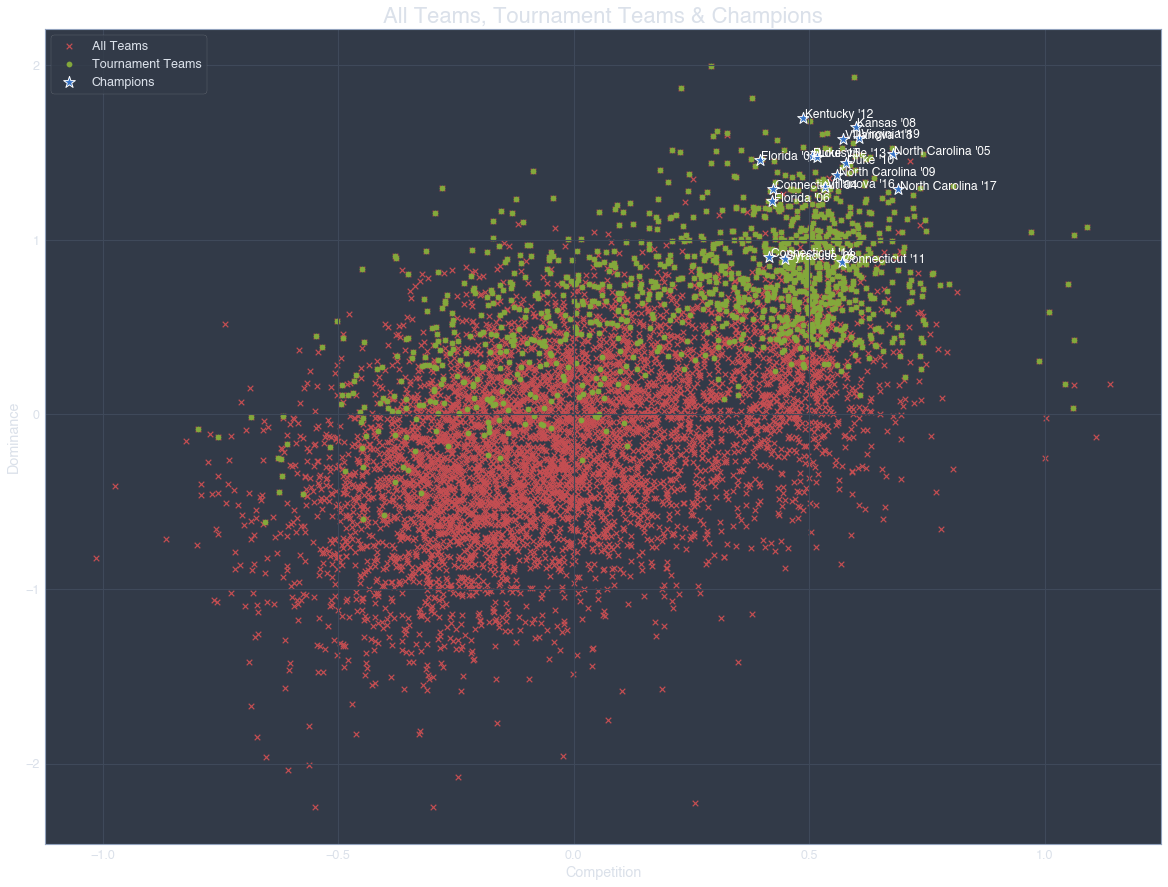

In [20]:
label_series = (
    tournament_df[is_champion]["TeamName"] + " '" +
    tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("All Teams, Tournament Teams & Champions", fontsize=22)
plt.scatter(summary_df["Competition"], summary_df["Dominance"], color='r', marker='x', label='All Teams');
plt.scatter(tournament_df["Competition"], tournament_df["Dominance"], color='g', label='Tournament Teams');
scatter_text(
    tournament_df[is_champion]["Competition"], tournament_df[is_champion]["Dominance"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

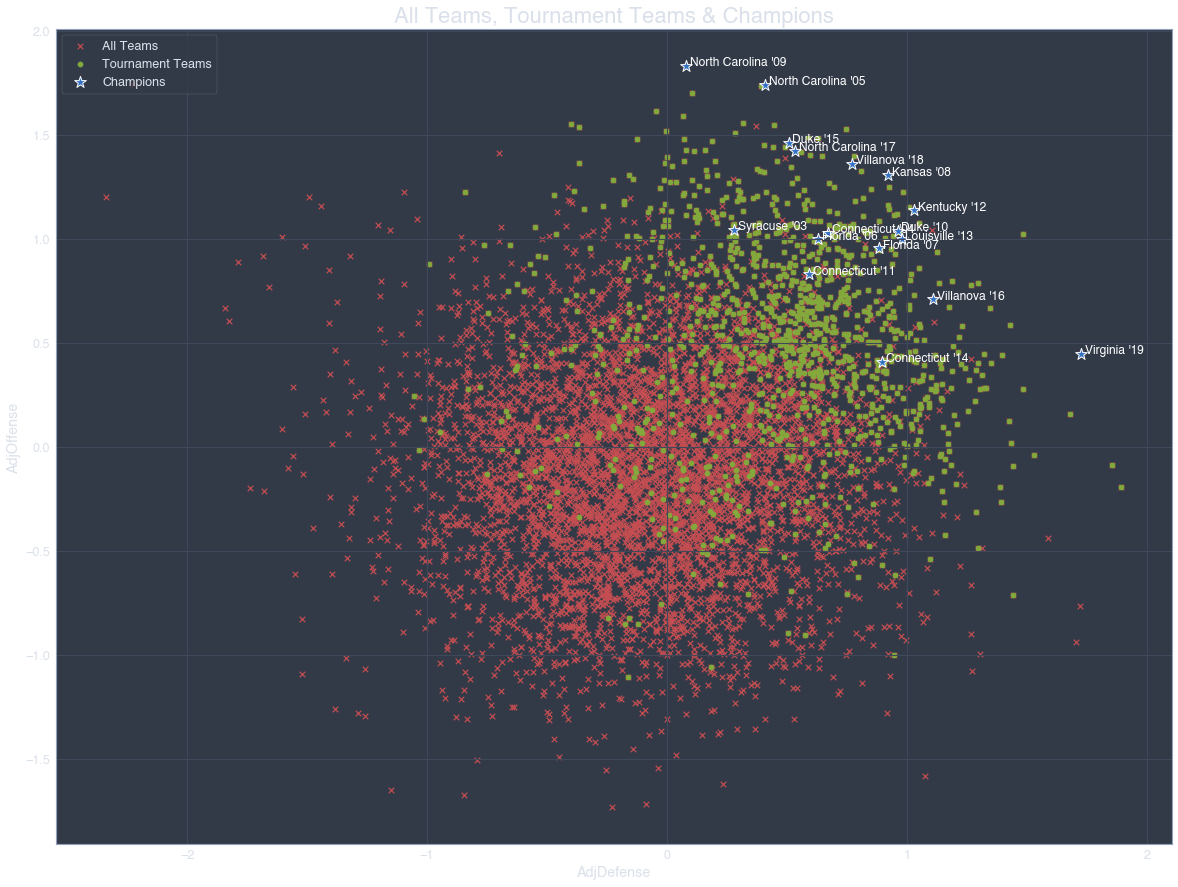

In [21]:
label_series = (
    tournament_df[is_champion]["TeamName"] + " '" +
    tournament_df[is_champion]["Season"].astype(str).str[-2:]
)

plt.figure(figsize=(20,15));
plt.title("All Teams, Tournament Teams & Champions", fontsize=22)
plt.scatter(summary_df["AdjDefense"], summary_df["AdjOffense"], color='r', marker='x', label='All Teams');
plt.scatter(tournament_df["AdjDefense"], tournament_df["AdjOffense"], color='g', label='Tournament Teams');
scatter_text(
    tournament_df[is_champion]["AdjDefense"], tournament_df[is_champion]["AdjOffense"],
    color='b', marker='*', s=150, label='Champions',
    labelseries=label_series,
    labelcolor='white'
);
plt.legend(loc='upper left');

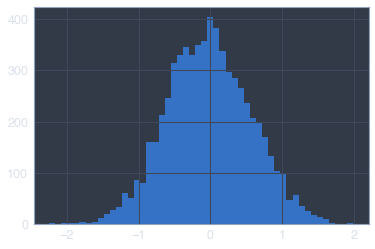

In [22]:
# Dominance follows a normal curve
plt.hist(summary_df["Dominance"], bins=50);

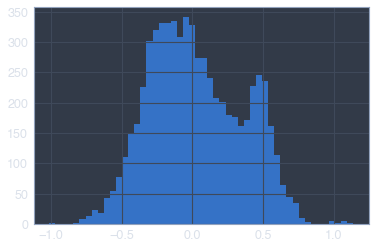

In [23]:
# Competition is a mix of two bell curves (one for elite teams and one for the rest)
plt.hist(summary_df["Competition"], bins=50);

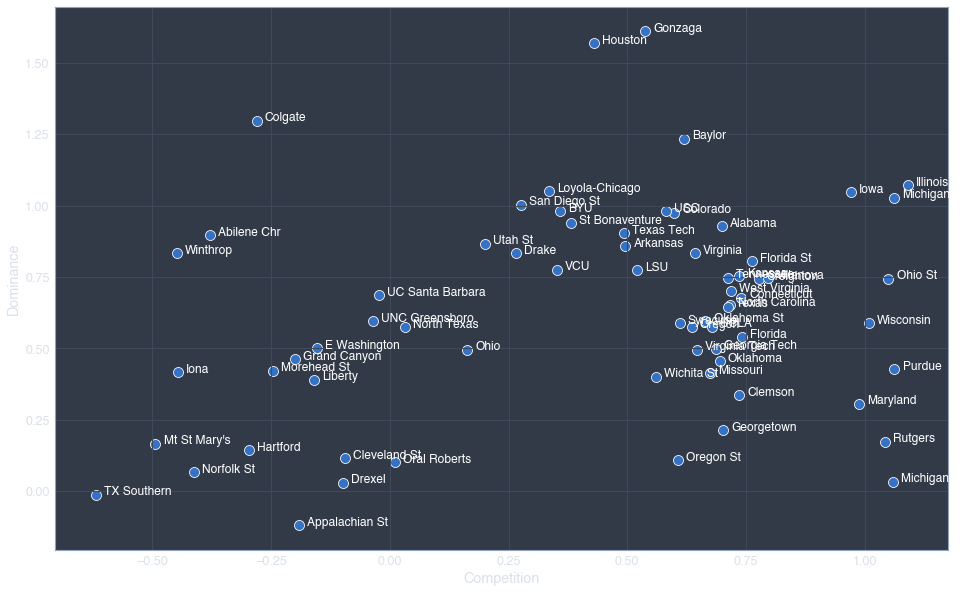

In [24]:
is_year = tournament_df["Season"] == YEAR
plt.figure(figsize=(16,10));
scatter_text(
    x=tournament_df[is_year]["Competition"],
    y=tournament_df[is_year]["Dominance"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

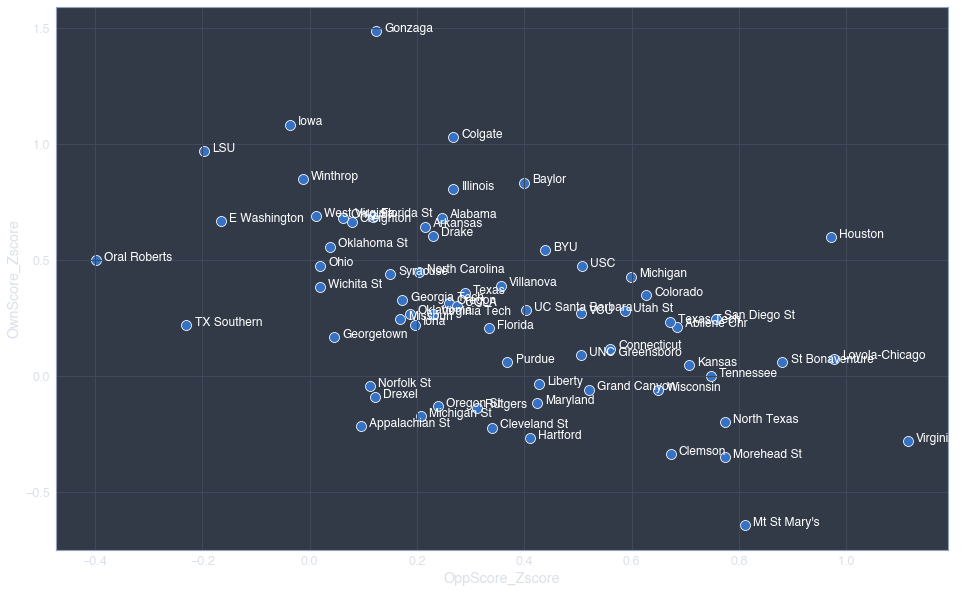

In [25]:
plt.figure(figsize=(16,10));
scatter_text(
    x=-tournament_df[is_year]["OppScore_Zscore"],
    y=tournament_df[is_year]["OwnScore_Zscore"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

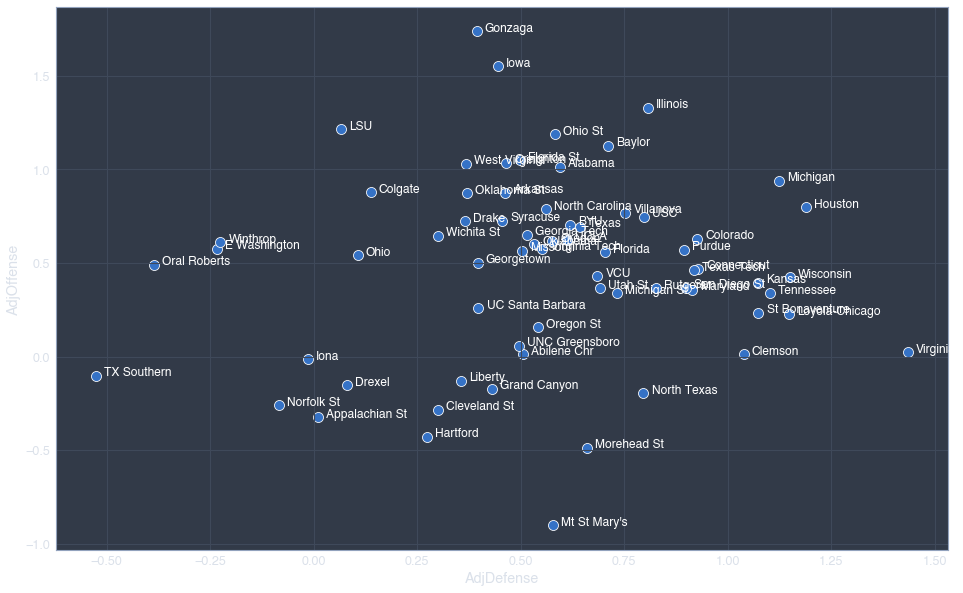

In [26]:
plt.figure(figsize=(16,10));
scatter_text(
    x=tournament_df[is_year]["AdjDefense"],
    y=tournament_df[is_year]["AdjOffense"],
    labelseries=tournament_df[is_year]["TeamName"],
    labelcolor="white",
    s=100,
);

In [27]:
# Top 25 Dominant teams
tournament_df.sort_values("Dominance", ascending=False)[:25]

,TeamID,TeamName,Season,OwnScore_Zscore,OppScore_Zscore,Rank,Rank_Zscore,Dominance,SOS,Competition,AdjOffense,AdjDefense,Seed,SeedInt,Wins
324,1211,Gonzaga,2019,1.398097,-0.598454,2.0,2.631592,1.996552,0.428798,0.291134,1.528392,0.747757,X01,1,3.0
430,1246,Kentucky,2015,0.743464,-1.188320,1.0,2.983577,1.931784,0.761735,0.594497,1.023853,1.485942,Y01,1,4.0
322,1211,Gonzaga,2017,1.066522,-0.804608,1.0,2.983577,1.871130,0.201651,0.228217,1.165688,0.923150,X01,1,5.0
462,1257,Louisville,2014,1.078797,-0.731865,2.0,2.629661,1.810663,0.384822,0.378050,1.252095,0.923663,Y04,4,2.0
428,1246,Kentucky,2012,0.912072,-0.785912,1.0,2.978297,1.697984,0.668364,0.486964,1.139258,1.030959,Y01,1,6.0
397,1242,Kansas,2010,0.921894,-0.758095,2.0,2.625762,1.679989,0.793980,0.500636,1.155844,1.009827,Y01,1,1.0
395,1242,Kansas,2008,1.024545,-0.621341,1.0,2.974721,1.645886,0.857537,0.599230,1.307276,0.921278,X01,1,6.0
318,1211,Gonzaga,2013,0.868779,-0.752179,4.0,2.323116,1.620958,0.393639,0.304961,1.005915,0.908242,Z01,1,1.0
263,1196,Florida,2013,0.479926,-1.138982,1.0,2.980068,1.618908,0.617583,0.406294,0.667199,1.344588,X03,3,3.0
320,1211,Gonzaga,2015,0.963646,-0.650415,6.0,2.152741,1.614061,0.440730,0.325759,1.111072,0.816646,X02,2,3.0


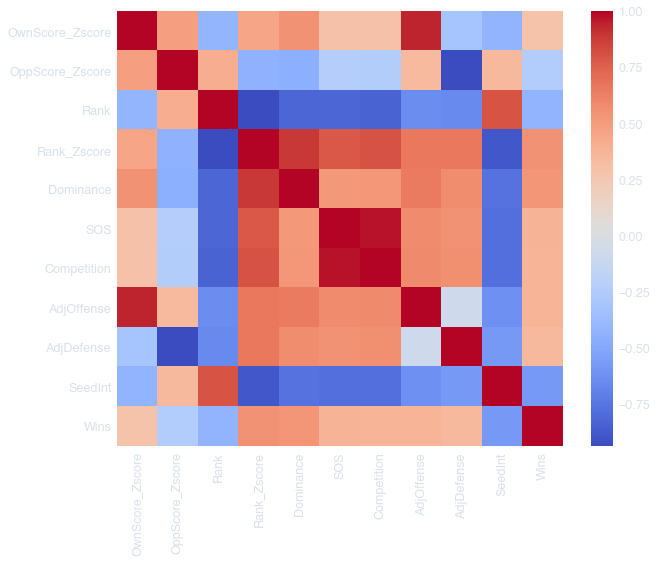

In [28]:
plt.figure(figsize=(10,8));
sns.heatmap(
    tournament_df.drop(["Season", "TeamID"], axis=1).corr(),
    cmap="coolwarm"
);

In [29]:
tournament_df.to_csv(f"{OUTPUT_DATA_DIR}/teams.csv", index=False)
summary_df.to_csv(f"{OUTPUT_DATA_DIR}/teams_full.csv", index=False)

In [30]:
# Get game training data
should_use_all_games = True
merge_df = summary_df if should_use_all_games else tournament_df

# FEATURE_COLS = list(set(merge_df.columns) - {"Season", "TeamID"})
FEATURE_COLS = [
    "OwnScore_Zscore", "OppScore_Zscore",
    "Competition", "AdjOffense", "AdjDefense"
]

def get_training_df(feature_cols):
    TOURNAMENT_COLS = ["Season", "TeamID"] + feature_cols

    training_df = reg_results_df.merge(
        merge_df[TOURNAMENT_COLS],
        left_on=["Season", "WTeamID"],
        right_on=["Season", "TeamID"]
    ).rename(columns={k: f"W{k}" for k in feature_cols}).drop("TeamID", axis=1)

    training_df = training_df.merge(
        merge_df[TOURNAMENT_COLS],
        left_on=["Season", "LTeamID"],
        right_on=["Season", "TeamID"]
    ).rename(columns={k: f"L{k}" for k in feature_cols}).drop("TeamID", axis=1)

    training_df["TeamID_A"] = training_df.apply(lambda x: min(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
    training_df["TeamID_B"] = training_df.apply(lambda x: max(x["WTeamID"], x["LTeamID"]), axis=1).astype(int)
    for col in tqdm(feature_cols):   
        training_df[f"{col}_A"] = training_df.apply(
            lambda x: x[f"W{col}"] if x["TeamID_A"] == x["WTeamID"] else x[f"L{col}"], axis=1
        )
        training_df[f"{col}_B"] = training_df.apply(
            lambda x: x[f"W{col}"] if x["TeamID_B"] == x["WTeamID"] else x[f"L{col}"], axis=1
        )

    training_df["Win_A"] = training_df["TeamID_A"] == training_df["WTeamID"]

    FINAL_COLS = (
        ["Season", "TeamID_A", "TeamID_B"] + 
        [f"{col}_A" for col in feature_cols] +
        [f"{col}_B" for col in feature_cols] +
        ["Win_A"]
    )
    training_df = training_df[FINAL_COLS]
    return training_df

training_df = get_training_df(FEATURE_COLS)
training_df

100%|██████████| 5/5 [00:08<00:00,  1.68s/it]


,Season,TeamID_A,TeamID_B,OwnScore_Zscore_A,OppScore_Zscore_A,Competition_A,AdjOffense_A,AdjDefense_A,OwnScore_Zscore_B,OppScore_Zscore_B,Competition_B,AdjOffense_B,AdjDefense_B,Win_A
0,2003,1104,1328,0.144799,-0.335313,0.652193,0.453735,0.661143,0.207507,-0.863963,0.504506,0.443371,1.117587,True
1,2003,1328,1400,0.207507,-0.863963,0.504506,0.443371,1.117587,0.935597,-0.181307,0.547710,1.192837,0.456054,False
2,2003,1328,1400,0.207507,-0.863963,0.504506,0.443371,1.117587,0.935597,-0.181307,0.547710,1.192837,0.456054,False
3,2003,1281,1328,0.297116,-0.342031,0.556451,0.558682,0.621052,0.207507,-0.863963,0.504506,0.443371,1.117587,True
4,2003,1328,1329,0.207507,-0.863963,0.504506,0.443371,1.117587,-0.064060,-0.740947,0.505393,0.172244,0.995004,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96685,2021,1131,1248,-0.331852,-0.146765,-0.374523,-0.530904,-0.029383,0.329626,0.486841,-0.487686,0.074585,-0.718316,True
96686,2021,1131,1248,-0.331852,-0.146765,-0.374523,-0.530904,-0.029383,0.329626,0.486841,-0.487686,0.074585,-0.718316,True
96687,2021,1137,1248,0.106370,0.419036,-0.490978,-0.150299,-0.652120,0.329626,0.486841,-0.487686,0.074585,-0.718316,True
96688,2021,1248,1259,0.329626,0.486841,-0.487686,0.074585,-0.718316,-0.086851,-0.264242,-0.474021,-0.335130,0.039448,False


In [31]:
training_df.to_csv(f"{OUTPUT_DATA_DIR}/games_training.csv", index=False)